In [1]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, add,GlobalAveragePooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from keras.utils import plot_model
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from matplotlib import pyplot as plt
import pickle
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Model 

In [3]:
def residual_block(input_tensor, filters, stride):
    if stride != 1 :
        shortcut = Conv2D(filters, kernel_size=(1, 1), padding='same', strides=stride)(input_tensor)
    else:
        shortcut = input_tensor

    x = Conv2D(filters, kernel_size=(3, 3), padding='same', strides=stride)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = add([x, shortcut])
#     x = Activation('relu')(x)

    return x


def layer_n(input_image,b1,b2,b3,b4,b5): #b1 = 5, b2 = 2, b3 = 4, b4 = 2, b5 = 3

    # low level feature extractor

    def_out = Conv2D(16, kernel_size = (3,3), input_shape=(400, 400, 1))(input_image)
    def_out = BatchNormalization()(def_out)
    def_out = Activation('relu')(def_out)

    # High level feature extractor

    x = def_out

    for _ in range(b1):
        x = residual_block(x,16,1)

    for _ in range(b2):
        x = residual_block(x,32,2)

    for _ in range(b3):
        x = residual_block(x,32,1)

    for _ in range(b4):
        x = residual_block(x,64,2)

    for _ in range(b5):
        x = residual_block(x,64,1)

    x = AveragePooling2D(pool_size=(2, 2))(x)
#     x=GlobalAveragePooling2D()(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    return x

In [ ]:
# input_image = tf.convert_to_tensor(np.random.rand(1, 400, 400, 3), np.float32)
# result = layer_n(input_image, 5, 2, 4, 2, 3)

In [ ]:
# print(result.shape)

In [5]:
inputs = Input(shape=(400, 400, 1))
result = layer_n(inputs, 3, 2, 2, 2, 3)
model = Model(inputs=inputs, outputs=result)

In [ ]:
# plot_model(model)

### Data Loading

In [3]:

train_datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
)


train_gen = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/si_detection_1/si_det_train_test_val/train",
    target_size=(400, 400),  # Adjust as per your image size
    batch_size=32,
    class_mode='sparse',
    color_mode = 'grayscale',
    seed=42,
    shuffle=True
)

val_test_datagen = ImageDataGenerator()

val_gen = val_test_datagen.flow_from_directory(
    "/content/drive/MyDrive/si_detection_1/si_det_train_test_val/val",
    target_size=(400, 400),  # Adjust as per your image size
    batch_size=32,
    class_mode='sparse',
    color_mode = 'grayscale',
    seed=42,
    shuffle=False,
)

test_gen = val_test_datagen.flow_from_directory(
    "/content/drive/MyDrive/si_detection_1/si_det_train_test_val/test",
    target_size=(400, 400),  # Adjust as per your image size
    batch_size=32,
    class_mode='sparse',
    color_mode = 'grayscale',
    seed=42,
    shuffle=False,
)

Found 4062 images belonging to 2 classes.
Found 1014 images belonging to 2 classes.
Found 563 images belonging to 2 classes.


In [7]:
unique_classes = np.unique(train_gen.classes)

# Calculate class weights
class_weights = compute_class_weight('balanced',classes = unique_classes,y=train_gen.classes)
class_weights_dict = dict(zip(unique_classes, class_weights))

In [ ]:
print(class_weights_dict)

{0: 1.0723336853220697, 1: 0.9368081180811808}


### Model training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint("/content/drive/MyDrive/si_detection_1/si_det_final_2.h5"
, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with ModelCheckpoint callback
hist = model.fit(train_gen, epochs=25,
                 validation_data=val_gen,
                 class_weight=class_weights_dict,
                 callbacks=[checkpoint])



Epoch 1/25
127/127 [==============================] - ETA: 0s - loss: 0.4639 - accuracy: 0.9077
Epoch 1: val_accuracy improved from -inf to 0.92505, saving model to /content/drive/MyDrive/si_detection_1/si_det_final_2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1149s 9s/step - loss: 0.4639 - accuracy: 0.9077 - val_loss: 0.1946 - val_accuracy: 0.9250
Epoch 2/25
127/127 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9818
Epoch 2: val_accuracy did not improve from 0.92505
127/127 [==============================] - 106s 837ms/step - loss: 0.0470 - accuracy: 0.9818 - val_loss: 0.2609 - val_accuracy: 0.9034
Epoch 3/25
127/127 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9874
Epoch 3: val_accuracy improved from 0.92505 to 0.97830, saving model to /content/drive/MyDrive/si_detection_1/si_det_final_2.h5
127/127 [==============================] - 115s 907ms/step - loss: 0.0420 - accuracy: 0.9874 - val_loss: 0.0895 - val_accuracy: 0.9783
Epoch 4/25
127/127 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9860
Epoch 4: val_accuracy did not improve from 0.97830
127/127 [==============================] - 111s 871ms/step - loss: 0.0453 - acc

### Model loading

In [4]:
# loading model and history
from keras.models import load_model

# Load the model
loaded_model = load_model("/content/drive/MyDrive/si_detection_1/si_det_final_2.h5")



### Model Evaluation

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming 'model' is your binary classification model and 'test_gen' is your test generator

# Get predicted probabilities for the positive class (class 1)
y_pred_probs = loaded_model.predict(test_gen)


y_pred = (y_pred_probs >= 0.3).astype(int)

# Get true labels from the test generator
y_true = test_gen.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional binary classification metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

18/18 [==============================] - 4s 224ms/step
Confusion Matrix:
[[258   5]
 [  2 298]]
Accuracy: 0.9875666074600356
Precision: 0.9834983498349835
Recall: 0.9933333333333333
F1 Score: 0.9883913764510779


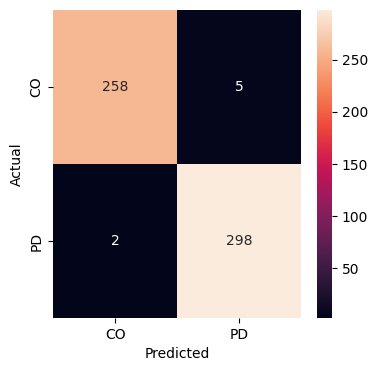

In [20]:
import seaborn as sns
# cm=conf_matrix
fig, ax = plt.subplots(figsize=(4,4))
# cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix,fmt='d', annot=True,xticklabels=['CO','PD'], yticklabels=['CO','PD'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

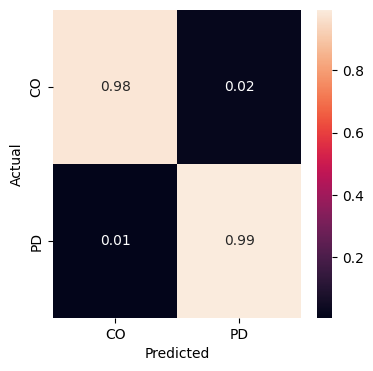

In [16]:
import seaborn as sns
cm=conf_matrix
fig, ax = plt.subplots(figsize=(4,4))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn,fmt='.2f', annot=True,xticklabels=['CO','PD'], yticklabels=['CO','PD'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)